In [1]:
#importing all needed libraries
import pandas as pd
import geopandas as gpd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
# PCA module
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import r2_score
import datetime

In [46]:
#sourcing all taxi databases for december 2018
dec_2018_yellow = pd.read_csv('yellow_tripdata_dec2018.csv')
dec_2018_fhv = pd.read_csv('fhv_tripdata_dec2018.csv') 

In [3]:
#visualising the dataset
dec_2018_yellow.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2018-12-01 00:28:22,2018-12-01 00:44:07,2,2.5,1,N,148,234,1,12.0,0.5,0.5,3.95,0.0,0.3,17.25
1,1,2018-12-01 00:52:29,2018-12-01 01:11:37,3,2.3,1,N,170,144,1,13.0,0.5,0.5,2.85,0.0,0.3,17.15
2,2,2018-12-01 00:12:52,2018-12-01 00:36:23,1,0.0,1,N,113,193,2,2.5,0.5,0.5,0.00,0.0,0.3,3.80
3,1,2018-12-01 00:35:08,2018-12-01 00:43:11,1,3.9,1,N,95,92,1,12.5,0.5,0.5,2.75,0.0,0.3,16.55
4,1,2018-12-01 00:21:54,2018-12-01 01:15:13,1,12.8,1,N,163,228,1,45.0,0.5,0.5,9.25,0.0,0.3,55.55


In [50]:
#renaming columns
dec_2018_yellow=dec_2018_yellow.rename(columns={"tpep_pickup_datetime":"pickup_time","tpep_dropoff_datetime":"dropofftime","PULocationID":"pickup_id","DOLocationID":"dropoff_id"})
dec_2018_fhv=dec_2018_fhv.rename(columns={"Pickup_DateTime":"pickup_time","DropOff_datetime":"dropofftime","PUlocationID":"pickup_id","DOlocationID":"dropoff_id"})

In [5]:
#filtering the dataset
ind = (dec_2018_yellow['passenger_count'] > 1) & (dec_2018_yellow['trip_distance'] > 0)
dec_2018_yellow1 = dec_2018_yellow[ind].copy()
dec_2018_yellow1.head()

,VendorID,pickup_time,dropofftime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,pickup_id,dropoff_id,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2018-12-01 00:28:22,2018-12-01 00:44:07,2,2.5,1,N,148,234,1,12.0,0.5,0.5,3.95,0.0,0.3,17.25
1,1,2018-12-01 00:52:29,2018-12-01 01:11:37,3,2.3,1,N,170,144,1,13.0,0.5,0.5,2.85,0.0,0.3,17.15
13,1,2018-12-01 00:44:02,2018-12-01 01:13:33,2,2.6,1,N,79,65,1,19.0,0.5,0.5,4.05,0.0,0.3,24.35
14,1,2018-12-01 00:30:12,2018-12-01 00:39:09,4,1.8,1,N,261,114,3,8.5,0.5,0.5,0.00,0.0,0.3,9.80
15,1,2018-12-01 00:45:34,2018-12-01 00:54:36,2,2.0,1,N,249,246,1,8.5,0.5,0.5,1.95,0.0,0.3,11.75


In [6]:
#dropping unnecessary columns
dec_2018_yellow1 = dec_2018_yellow1.drop(columns=["VendorID","passenger_count","trip_distance","RatecodeID","store_and_fwd_flag","payment_type","fare_amount","extra","mta_tax","tip_amount","tolls_amount","improvement_surcharge","total_amount"])

In [7]:
#converting to datetime
dec_2018_yellow1['pickup_time'] =  pd.to_datetime(dec_2018_yellow1['pickup_time'])
dec_2018_yellow1['dropofftime'] =  pd.to_datetime(dec_2018_yellow1['dropofftime'])

In [8]:
#dropping NAs
dec_2018_yellow1 = dec_2018_yellow1.dropna()

In [9]:
#visualising the dataset
dec_2018_yellow1.head()

,pickup_time,dropofftime,pickup_id,dropoff_id
0,2018-12-01 00:28:22,2018-12-01 00:44:07,148,234
1,2018-12-01 00:52:29,2018-12-01 01:11:37,170,144
13,2018-12-01 00:44:02,2018-12-01 01:13:33,79,65
14,2018-12-01 00:30:12,2018-12-01 00:39:09,261,114
15,2018-12-01 00:45:34,2018-12-01 00:54:36,249,246


In [10]:
#creating new dataset
hotspot_df = dec_2018_yellow1

In [11]:
#dropping taxi id = 264
hotspot_df = hotspot_df[~hotspot_df.eq(264).any(1)]

In [12]:
#dropping taxi id = 264
hotspot_df = hotspot_df[~hotspot_df.eq(265).any(1)]

In [13]:
hotspot_df.shape

(2306657, 4)

In [14]:
#filtering only the holiday weeks
hotspot_df_hols = hotspot_df[(hotspot_df['pickup_time'] >= np.datetime64('2018-12-18')) & (hotspot_df['pickup_time'] <= np.datetime64('2019-01-01'))]
hotspot_df_hols.head()

,pickup_time,dropofftime,pickup_id,dropoff_id
4967450,2018-12-18 00:23:00,2018-12-18 00:26:48,41,74
4967779,2018-12-18 23:51:10,2018-12-19 00:04:35,234,50
4967938,2018-12-18 00:00:03,2018-12-18 00:26:40,132,43
4968522,2018-12-18 00:00:10,2018-12-18 00:06:32,90,230
4968705,2018-12-18 00:04:16,2018-12-18 00:21:33,90,151


In [15]:
#neccessary conditions to filter based on time
hotspot_df_hols['drop_time'] = hotspot_df_hols['dropofftime'].dt.time
hotspot_df_hols.head()

/Users/akashyadav/Desktop/nyuclass/ADSUncorrupted/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,pickup_time,dropofftime,pickup_id,dropoff_id,drop_time
4967450,2018-12-18 00:23:00,2018-12-18 00:26:48,41,74,00:26:48
4967779,2018-12-18 23:51:10,2018-12-19 00:04:35,234,50,00:04:35
4967938,2018-12-18 00:00:03,2018-12-18 00:26:40,132,43,00:26:40
4968522,2018-12-18 00:00:10,2018-12-18 00:06:32,90,230,00:06:32
4968705,2018-12-18 00:04:16,2018-12-18 00:21:33,90,151,00:21:33


In [16]:
def filter_time(row):
    bool_time = False
    #if dec_2018_hols.drop_time >= datetime.datetime.strptime('11:00:00','%H:%M:%S').time():
    if row >= datetime.datetime.strptime('11:00:00','%H:%M:%S').time():
        bool_time = True
    #if dec_2018_hols.drop_time <= datetime.datetime.strptime('04:00:00','%H:%M:%S').time():
    if row <= datetime.datetime.strptime('04:00:00','%H:%M:%S').time():
        bool_time = True
    return bool_time

In [17]:
#applying filter condition
hotspot_df_hols = hotspot_df_hols[hotspot_df_hols['drop_time'].apply(filter_time)]

In [18]:
#visualising new dataset
hotspot_df_hols.head()

,pickup_time,dropofftime,pickup_id,dropoff_id,drop_time
4967450,2018-12-18 00:23:00,2018-12-18 00:26:48,41,74,00:26:48
4967779,2018-12-18 23:51:10,2018-12-19 00:04:35,234,50,00:04:35
4967938,2018-12-18 00:00:03,2018-12-18 00:26:40,132,43,00:26:40
4968522,2018-12-18 00:00:10,2018-12-18 00:06:32,90,230,00:06:32
4968705,2018-12-18 00:04:16,2018-12-18 00:21:33,90,151,00:21:33


In [19]:
#creating pickup counts per taxi zone
pickup_count = hotspot_df_hols.groupby('pickup_id').agg({'pickup_time':'count'})
pickup_count 

,pickup_time
pickup_id,
1,18
2,1
3,7
4,1424
5,1
...,...
259,18
260,379
261,6538


In [20]:
#creating dropoff counts per taxi zone
dropoff_count = hotspot_df_hols.groupby('dropoff_id').agg({'dropofftime':'count'})
dropoff_count 

,dropofftime
dropoff_id,
1,1355
3,69
4,3926
5,5
6,15
...,...
259,114
260,974
261,4345


In [22]:
#merging pickups and dropoffs 
orgdes = pickup_count.merge(dropoff_count, right_on = dropoff_count.index, left_on = pickup_count.index)
orgdes.shape

(248, 3)

In [23]:
#renaming columns
orgdes = orgdes.rename(columns={"key_0":"taxizone","pickup_time":"pickups","dropofftime":"dropoffs"})

In [24]:
#creating standardised datasets
col_list = ["taxizone"]

ognorm = pd.DataFrame(data=orgdes,columns=col_list)
ognorm.head()

,taxizone
0,1
1,3
2,4
3,5
4,6


In [25]:
#standardising
mu_p = orgdes.pickups.mean()
std_p = orgdes.pickups.std()
mu_d = orgdes.dropoffs.mean()
std_d = orgdes.dropoffs.std()


ognorm['normpickups'] = (orgdes.pickups-mu_p)/std_p
ognorm['normdropoff'] = (orgdes.dropoffs-mu_d)/std_d

ognorm.head()

,taxizone,normpickups,normdropoff
0,1,-0.439125,-0.288300
1,3,-0.440643,-0.489247
2,4,-0.245112,0.113439
3,5,-0.441471,-0.499248
4,6,-0.441471,-0.497685


In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [28]:
#Trying silhoutte score 
range_n_clusters = range(2,7)
for n_clusters in range_n_clusters: #try different numbers of clusters
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(ognorm.iloc[:,2:])
    #report average Silhouette score
    silhouette_avg = silhouette_score(ognorm.iloc[:,2:], cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.8415801151568307
For n_clusters =3, the average silhouette_score is :0.8445349697209596
For n_clusters =4, the average silhouette_score is :0.841385706692471
For n_clusters =5, the average silhouette_score is :0.7895622503835783
For n_clusters =6, the average silhouette_score is :0.791971127049852


In [29]:
#trying the k means clustering
n=3
km=KMeans(random_state=100,n_clusters=n)
res=km.fit_predict(ognorm.iloc[:,2:])
res

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0,
       1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 1, 1,
       2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 1, 1,
       0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 0, 2, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 1], dtype=int32)

In [30]:
#creating a cluster dictionary
clust_name=[]
clust_name={z:res[z] for z in ognorm.index}

In [31]:
#attaching clusters back to original dataset
ognorm['cluster']= ognorm.index.map(clust_name)
ognorm

,taxizone,normpickups,normdropoff,cluster
0,1,-0.439125,-0.288300,0
1,3,-0.440643,-0.489247,0
2,4,-0.245112,0.113439,0
3,5,-0.441471,-0.499248,0
4,6,-0.441471,-0.497685,0
...,...,...,...,...
243,259,-0.439125,-0.482216,0
244,260,-0.389311,-0.347834,0
245,261,0.460566,0.178911,0
246,262,0.662996,1.249121,2


In [32]:
#loading taxi zone shapefiles
tzs=gpd.read_file('taxi_zones/taxi_zones.shp')
tzs.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.310 144283.336, 936046.565 14..."


In [33]:
# merge with taxi zone
ognorm =tzs.merge(ognorm, left_on = 'LocationID', right_on ='taxizone')
ognorm.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,taxizone,normpickups,normdropoff,cluster
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",1,-0.439125,-0.288300,0
1,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ...",3,-0.440643,-0.489247,0
2,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",4,-0.245112,0.113439,0
3,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.310 144283.336, 936046.565 14...",5,-0.441471,-0.499248,0
4,6,0.150491,0.000606,Arrochar/Fort Wadsworth,6,Staten Island,"POLYGON ((966568.747 158679.855, 966615.256 15...",6,-0.441471,-0.497685,0


/Users/akashyadav/Desktop/nyuclass/ADSUncorrupted/lib/python3.6/site-packages/geopandas/plotting.py:466: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  FutureWarning,


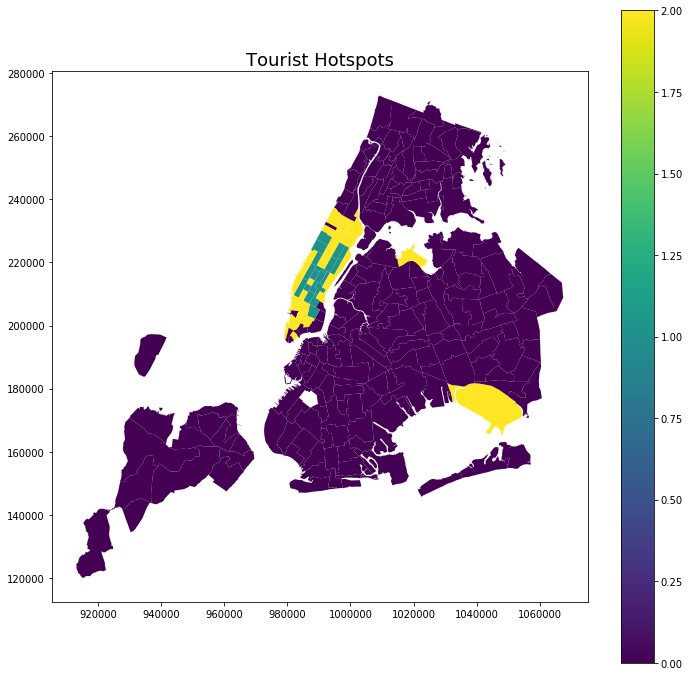

In [34]:
#visualize the resulting clustering
f, ax = plt.subplots( figsize=(12, 12))
ax.set_title('Tourist Hotspots', fontsize=18)
ognorm.plot(axes=ax, column="cluster" ,legend=True)

In [35]:
#filtering condition
ind1 = (ognorm.cluster == 1)

In [36]:
#getting high tourist activity zones
high_tourist_zones = ognorm[ind1].copy()
high_tourist_zones

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,taxizone,normpickups,normdropoff,cluster
44,48,0.043747,0.000094,Clinton East,48,Manhattan,"POLYGON ((986694.313 214463.846, 986568.184 21...",48,3.288519,3.708151,1
64,68,0.049337,0.000111,East Chelsea,68,Manhattan,"POLYGON ((983690.405 209040.369, 983550.612 20...",68,2.226415,2.456370,1
75,79,0.042625,0.000108,East Village,79,Manhattan,"POLYGON ((988746.067 202151.955, 988733.885 20...",79,2.581737,2.512622,1
99,107,0.038041,0.000075,Gramercy,107,Manhattan,"POLYGON ((989131.643 205749.904, 989084.531 20...",107,2.015429,2.054631,1
130,141,0.041514,0.000077,Lenox Hill West,141,Manhattan,"POLYGON ((994839.073 216123.698, 994786.740 21...",141,2.067727,2.651848,1
131,142,0.038176,0.000076,Lincoln Square East,142,Manhattan,"POLYGON ((989380.305 218980.247, 989359.803 21...",142,3.640116,3.388448,1
150,161,0.035804,0.000072,Midtown Center,161,Manhattan,"POLYGON ((991081.026 214453.698, 990952.644 21...",161,4.153712,3.870972,1
151,162,0.035270,0.000048,Midtown East,162,Manhattan,"POLYGON ((992224.354 214415.293, 992096.999 21...",162,3.192616,2.870922,1
152,163,0.034177,0.000041,Midtown North,163,Manhattan,"POLYGON ((989412.663 219020.943, 990045.841 21...",163,2.757122,2.592783,1
153,164,0.035772,0.000056,Midtown South,164,Manhattan,"POLYGON ((988787.425 210315.593, 988662.868 21...",164,2.551932,2.524342,1


In [37]:
#filtering condition
ind2 = (ognorm.cluster == 2)

In [39]:
#getting high tourist activity zones
mid_tourist_zones = ognorm[ind2].copy()
mid_tourist_zones

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,taxizone,normpickups,normdropoff,cluster
11,13,0.050281,0.000149,Battery Park City,13,Manhattan,"POLYGON ((980801.310 201248.869, 980697.386 20...",13,0.491061,0.627684,2
37,41,0.052793,0.000143,Central Harlem,41,Manhattan,"POLYGON ((998716.913 234240.397, 999458.736 23...",41,-0.026675,0.400641,2
39,43,0.099739,0.000380,Central Park,43,Manhattan,"POLYGON ((991852.973 217950.807, 991725.244 21...",43,1.750904,1.433506,2
46,50,0.055748,0.000173,Clinton West,50,Manhattan,"POLYGON ((985170.372 221087.389, 985817.170 22...",50,0.437107,0.890666,2
70,74,0.110291,0.000295,East Harlem North,74,Manhattan,"MULTIPOLYGON (((1002572.276 236761.574, 100256...",74,0.005063,0.548149,2
71,75,0.087664,0.000241,East Harlem South,75,Manhattan,"POLYGON ((1000577.175 228028.553, 1001238.138 ...",75,0.302016,0.895041,2
82,87,0.036902,0.000067,Financial District North,87,Manhattan,"POLYGON ((983217.971 196831.021, 983250.399 19...",87,0.238127,0.345482,2
85,90,0.030759,0.000055,Flatiron,90,Manhattan,"POLYGON ((985265.129 208165.863, 985125.733 20...",90,1.334452,1.096145,2
95,100,0.024813,0.000037,Garment District,100,Manhattan,"POLYGON ((987770.527 212686.678, 987638.873 21...",100,1.773948,1.548043,2
102,113,0.032745,0.000058,Greenwich Village North,113,Manhattan,"POLYGON ((986643.640 204346.324, 986592.535 20...",113,1.311684,1.128647,2


RUNNING THE CODE WITH UBER/LYFT DATA

In [47]:
#dropping all shared rides in fhv df
dec_2018_fhv = dec_2018_fhv[dec_2018_fhv['SR_Flag'].isna()]
dec_2018_fhv.head()

,Pickup_DateTime,DropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Dispatching_base_number,Dispatching_base_num
0,2018-12-27 11:34:53,2018-12-27 11:50:29,NaN,NaN,NaN,B03035,NaN
1,2018-12-27 11:35:11,2018-12-27 11:40:35,NaN,NaN,NaN,B03035,NaN
2,2018-12-27 11:35:12,2018-12-27 12:00:54,NaN,NaN,NaN,B03035,NaN
3,2018-12-02 08:42:00,2018-12-02 08:49:00,NaN,NaN,NaN,B00054,NaN
4,2018-12-27 11:35:31,2018-12-27 11:55:37,NaN,NaN,NaN,B03035,NaN


In [56]:
#dropping unnecessary columns
dec_2018_fhv1 = dec_2018_fhv.drop(columns=["Dispatching_base_number","Dispatching_base_num"])
dec_2018_fhv1.head()

,pickup_time,dropofftime,pickup_id,dropoff_id,SR_Flag
0,2018-12-27 11:34:53,2018-12-27 11:50:29,NaN,NaN,NaN
1,2018-12-27 11:35:11,2018-12-27 11:40:35,NaN,NaN,NaN
2,2018-12-27 11:35:12,2018-12-27 12:00:54,NaN,NaN,NaN
3,2018-12-02 08:42:00,2018-12-02 08:49:00,NaN,NaN,NaN
4,2018-12-27 11:35:31,2018-12-27 11:55:37,NaN,NaN,NaN


In [57]:
#dropping unnecessary columns
dec_2018_fhv1 = dec_2018_fhv1.drop(columns=["SR_Flag"])

In [58]:
#converting to datetime
dec_2018_fhv1['pickup_time'] =  pd.to_datetime(dec_2018_fhv1['pickup_time'])
dec_2018_fhv1['dropofftime'] =  pd.to_datetime(dec_2018_fhv1['dropofftime'])

In [59]:
#dropping NAs
dec_2018_fhv2=dec_2018_fhv1.dropna()
dec_2018_fhv2.head()

,pickup_time,dropofftime,pickup_id,dropoff_id
77,2018-12-02 09:53:30,2018-12-02 10:15:53,179.0,181.0
81,2018-12-02 18:21:29,2018-12-02 18:42:30,161.0,79.0
83,2018-12-02 23:01:41,2018-12-02 23:17:06,256.0,225.0
90,2018-12-04 18:31:25,2018-12-04 19:00:32,65.0,50.0
91,2018-12-04 18:31:27,2018-12-04 18:58:50,95.0,132.0


In [60]:
#converting float to int for easier appends and joins
dec_2018_fhv2.pickup_id = dec_2018_fhv2.pickup_id.astype(int)
dec_2018_fhv2.dropoff_id = dec_2018_fhv2.dropoff_id.astype(int)

/Users/akashyadav/Desktop/nyuclass/ADSUncorrupted/lib/python3.6/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [61]:
#visualising
dec_2018_fhv2.head()

,pickup_time,dropofftime,pickup_id,dropoff_id
77,2018-12-02 09:53:30,2018-12-02 10:15:53,179,181
81,2018-12-02 18:21:29,2018-12-02 18:42:30,161,79
83,2018-12-02 23:01:41,2018-12-02 23:17:06,256,225
90,2018-12-04 18:31:25,2018-12-04 19:00:32,65,50
91,2018-12-04 18:31:27,2018-12-04 18:58:50,95,132


In [62]:
#creating new dataset
hotspot_df_fhv = dec_2018_fhv2

In [63]:
#dropping taxi id = 264
hotspot_df_fhv = hotspot_df_fhv[~hotspot_df_fhv.eq(264).any(1)]

In [64]:
#dropping taxi id = 264
hotspot_df_fhv = hotspot_df_fhv[~hotspot_df_fhv.eq(265).any(1)]

In [65]:
#filtering only the holiday weeks
hotspot_df_fhv_hols = hotspot_df_fhv[(hotspot_df_fhv['pickup_time'] >= np.datetime64('2018-12-18')) & (hotspot_df_fhv['pickup_time'] <= np.datetime64('2019-01-01'))]
hotspot_df_fhv_hols.head()

,pickup_time,dropofftime,pickup_id,dropoff_id
82629,2018-12-24 14:38:00,2018-12-24 15:41:00,137,147
82630,2018-12-19 10:22:00,2018-12-19 10:28:00,78,79
102359,2018-12-27 07:09:00,2018-12-27 08:24:00,213,213
107478,2018-12-27 14:37:00,2018-12-27 14:52:00,126,47
130591,2018-12-18 05:57:38,2018-12-18 09:54:10,186,233


In [69]:
#neccessary conditions to filter based on time
hotspot_df_fhv_hols['drop_time'] = hotspot_df_fhv_hols['dropofftime'].dt.time
hotspot_df_fhv_hols.head()

/Users/akashyadav/Desktop/nyuclass/ADSUncorrupted/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,pickup_time,dropofftime,pickup_id,dropoff_id,drop_time
82629,2018-12-24 14:38:00,2018-12-24 15:41:00,137,147,15:41:00
82630,2018-12-19 10:22:00,2018-12-19 10:28:00,78,79,10:28:00
102359,2018-12-27 07:09:00,2018-12-27 08:24:00,213,213,08:24:00
107478,2018-12-27 14:37:00,2018-12-27 14:52:00,126,47,14:52:00
130591,2018-12-18 05:57:38,2018-12-18 09:54:10,186,233,09:54:10


In [70]:
#applying filter condition
hotspot_df_fhv_hols = hotspot_df_fhv_hols[hotspot_df_fhv_hols['drop_time'].apply(filter_time)]

In [71]:
#appending all taxi databases together
hotspot = hotspot_df_hols.append(hotspot_df_fhv_hols, ignore_index=True)

In [72]:
#creating pickup counts per taxi zone
all_pu = hotspot.groupby('pickup_id').agg({'pickup_time':'count'})
all_pu 

,pickup_time
pickup_id,
0,237
1,899
2,4
3,8136
4,19887
...,...
259,9360
260,20419
261,29491


In [73]:
#creating dropoff counts per taxi zone
all_do = hotspot.groupby('dropoff_id').agg({'dropofftime':'count'})
all_do 

,dropofftime
dropoff_id,
0,2612
1,34771
2,17
3,8355
4,20681
...,...
259,12491
260,23589
261,24568


In [75]:
#merging pickups and dropoffs 
tour = all_pu.merge(all_do, right_on = all_do.index, left_on = all_pu.index)
tour.head()

,key_0,pickup_time,dropofftime
0,0,237,2612
1,1,899,34771
2,2,4,17
3,3,8136,8355
4,4,19887,20681


In [76]:
#renaming columns
tour = tour.rename(columns={"key_0":"taxizone","pickup_time":"pickups","dropofftime":"dropoffs"})

In [77]:
#creating standardised datasets
col_list = ["taxizone"]

tournorm = pd.DataFrame(data=tour,columns=col_list)
tournorm.head()

,taxizone
0,0
1,1
2,2
3,3
4,4


In [78]:
#standardising
mu_p1 = tour.pickups.mean()
std_p1 = tour.pickups.std()
mu_d1 = tour.dropoffs.mean()
std_d1 = tour.dropoffs.std()


tournorm['normpickups'] = (tour.pickups-mu_p1)/std_p1
tournorm['normdropoff'] = (tour.dropoffs-mu_d1)/std_d1

tournorm.head()

,taxizone,normpickups,normdropoff
0,0,-0.935858,-0.875174
1,1,-0.907061,0.595353
2,2,-0.945993,-0.993835
3,3,-0.592255,-0.612565
4,4,-0.081092,-0.048937


In [81]:
#Trying silhoutte score 
range_n_clusters = range(2,7)
for n_clusters in range_n_clusters: #try different numbers of clusters
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(tournorm.iloc[:,1:])
    #report average Silhouette score
    silhouette_avg = silhouette_score(tournorm.iloc[:,1:], cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.6870601442332953
For n_clusters =3, the average silhouette_score is :0.6363833752776593
For n_clusters =4, the average silhouette_score is :0.5709652206696891
For n_clusters =5, the average silhouette_score is :0.5657857133937922
For n_clusters =6, the average silhouette_score is :0.5611252468823303


In [82]:
#trying the k means clustering
n=2
km=KMeans(random_state=100,n_clusters=n)
res=km.fit_predict(tournorm.iloc[:,1:])
res

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
      dtype=int32)

In [84]:
#creating a cluster dictionary
clust_name=[]
clust_name={z:res[z] for z in tournorm.index}

In [85]:
#attaching clusters back to original dataset
tournorm['cluster']= tournorm.index.map(clust_name)
tournorm

,taxizone,normpickups,normdropoff,cluster
0,0,-0.935858,-0.875174,0
1,1,-0.907061,0.595353,0
2,2,-0.945993,-0.993835,0
3,3,-0.592255,-0.612565,0
4,4,-0.081092,-0.048937,0
...,...,...,...,...
256,259,-0.539012,-0.423439,0
257,260,-0.057951,0.084037,0
258,261,0.336677,0.128803,0
259,262,0.320147,0.428131,0


In [86]:
# merge with taxi zone
tournorm =tzs.merge(tournorm, left_on = 'LocationID', right_on ='taxizone')
tournorm.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,taxizone,normpickups,normdropoff,cluster
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",1,-0.907061,0.595353,0
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343...",2,-0.945993,-0.993835,0
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ...",3,-0.592255,-0.612565,0
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",4,-0.081092,-0.048937,0
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.310 144283.336, 936046.565 14...",5,-0.890444,-0.926846,0


/Users/akashyadav/Desktop/nyuclass/ADSUncorrupted/lib/python3.6/site-packages/geopandas/plotting.py:466: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  FutureWarning,


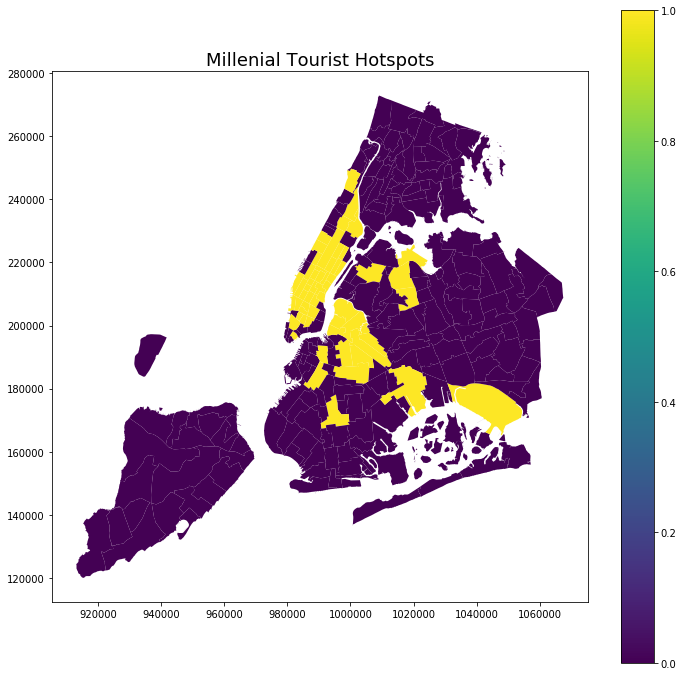

In [89]:
#visualize the resulting clustering
f, ax = plt.subplots( figsize=(12, 12))
ax.set_title('Millenial Tourist Hotspots', fontsize=18)
tournorm.plot(axes=ax, column="cluster" ,legend=True)

In [88]:
#filtering condition
ind3 = (tournorm.cluster == 1)

In [90]:
#getting high tourist activity zones
millenial_tourist_zones = tournorm[ind3].copy()
millenial_tourist_zones

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,taxizone,normpickups,normdropoff,cluster
6,7,0.107417,0.000390,Astoria,7,Queens,"POLYGON ((1010804.218 218919.641, 1011049.165 ...",7,1.331815,1.609528,1
16,17,0.093523,0.000323,Bedford,17,Brooklyn,"POLYGON ((1000036.904 194829.434, 1000276.454 ...",17,0.696026,0.883707,1
35,36,0.087051,0.000248,Bushwick North,36,Brooklyn,"POLYGON ((1008497.035 195728.645, 1008702.936 ...",36,0.735524,0.893629,1
36,37,0.142810,0.000452,Bushwick South,37,Brooklyn,"POLYGON ((1002791.711 196025.081, 1002823.637 ...",37,1.117667,1.421728,1
40,41,0.052793,0.000143,Central Harlem,41,Manhattan,"POLYGON ((998716.913 234240.397, 999458.736 23...",41,0.519027,0.639983,1
41,42,0.092709,0.000264,Central Harlem North,42,Manhattan,"POLYGON ((1002413.191 243934.560, 1002388.021 ...",42,0.776979,0.953577,1
42,43,0.099739,0.000380,Central Park,43,Manhattan,"POLYGON ((991852.973 217950.807, 991725.244 21...",43,0.847274,0.827005,1
47,48,0.043747,0.000094,Clinton East,48,Manhattan,"POLYGON ((986694.313 214463.846, 986568.184 21...",48,3.486259,3.542033,1
60,61,0.117311,0.000511,Crown Heights North,61,Brooklyn,"POLYGON ((1003897.089 188278.650, 1003939.593 ...",61,1.744799,2.060806,1
67,68,0.049337,0.000111,East Chelsea,68,Manhattan,"POLYGON ((983690.405 209040.369, 983550.612 20...",68,2.497080,2.830982,1
